In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin
from tqdm import tqdm
from portiloopml.portiloop_python.ANN.wamsley_utils import detect_lacourse
import os

In [ ]:


def shift_numpy(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

class FIR:
    def __init__(self, nb_channels, coefficients, buffer=None):
        
        self.coefficients = np.expand_dims(np.array(coefficients), axis=1)
        self.taps = len(self.coefficients)
        self.nb_channels = nb_channels
        self.buffer = np.array(buffer) if buffer is not None else np.zeros((self.taps, self.nb_channels))
    
    def filter(self, x):
        self.buffer = shift_numpy(self.buffer, 1, x)
        filtered = np.sum(self.buffer * self.coefficients, axis=0)
        return filtered

    
class FilterPipeline:
    def __init__(self,
                 nb_channels,
                 sampling_rate,
                 power_line_fq=60,
                 use_custom_fir=False,
                 custom_fir_order=20,
                 custom_fir_cutoff=30,
                 alpha_avg=0.1,
                 alpha_std=0.001,
                 epsilon=0.000001,
                 filter_args=[]):
        if len(filter_args) > 0:
            use_fir, use_notch, use_std = filter_args
        else:
            use_fir=True,
            use_notch=False,
            use_std=True
        self.use_fir = use_fir
        self.use_notch = use_notch
        self.use_std = use_std
        self.nb_channels = nb_channels
        assert power_line_fq in [50, 60], f"The only supported power line frequencies are 50 Hz and 60 Hz"
        if power_line_fq == 60:
            self.notch_coeff1 = -0.12478308884588535
            self.notch_coeff2 = 0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.12478308884588535
            self.notch_coeff5 = 0.99364593398236511
        else:
            self.notch_coeff1 = -0.61410695998423581
            self.notch_coeff2 =  0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.61410695998423581
            self.notch_coeff5 = 0.99364593398236511
        self.dfs = [np.zeros(self.nb_channels), np.zeros(self.nb_channels)]
        
        self.moving_average = None
        self.moving_variance = np.zeros(self.nb_channels)
        self.ALPHA_AVG = alpha_avg
        self.ALPHA_STD = alpha_std
        self.EPSILON = epsilon
        
        if use_custom_fir:
            self.fir_coef = firwin(numtaps=custom_fir_order+1, cutoff=custom_fir_cutoff, fs=sampling_rate)
        else:
            self.fir_coef = [
                0.001623780150148094927192721215192250384,
                0.014988684599373741992978104065059596905,
                0.021287595318265635502275046064823982306,
                0.007349500393709578957568417933998716762,
                -0.025127515717112181709014251396183681209,
                -0.052210507359822452833064687638398027048,
                -0.039273839505489904766477593511808663607,
                0.033021568427940004020193498490698402748,
                0.147606943281569008563636202779889572412,
                0.254000252034505602516389899392379447818,
                0.297330876398883392486283128164359368384,
                0.254000252034505602516389899392379447818,
                0.147606943281569008563636202779889572412,
                0.033021568427940004020193498490698402748,
                -0.039273839505489904766477593511808663607,
                -0.052210507359822452833064687638398027048,
                -0.025127515717112181709014251396183681209,
                0.007349500393709578957568417933998716762,
                0.021287595318265635502275046064823982306,
                0.014988684599373741992978104065059596905,
                0.001623780150148094927192721215192250384]
        self.fir = FIR(self.nb_channels, self.fir_coef)
        
    def filter(self, value):
        """
        value: a numpy array of shape (data series, channels)
        """
        for i, x in enumerate(value):  # loop over the data series
            # FIR:
            if self.use_fir:
                x = self.fir.filter(x)
            # notch:
            if self.use_notch:
                denAccum = (x - self.notch_coeff1 * self.dfs[0]) - self.notch_coeff2 * self.dfs[1]
                x = (self.notch_coeff3 * denAccum + self.notch_coeff4 * self.dfs[0]) + self.notch_coeff5 * self.dfs[1]
                self.dfs[1] = self.dfs[0]
                self.dfs[0] = denAccum
            # standardization:
            if self.use_std:
                if self.moving_average is not None:
                    delta = x - self.moving_average
                    self.moving_average = self.moving_average + self.ALPHA_AVG * delta
                    self.moving_variance = (1 - self.ALPHA_STD) * (self.moving_variance + self.ALPHA_STD * delta**2)
                    moving_std = np.sqrt(self.moving_variance)
                    x = (x - self.moving_average) / (moving_std + self.EPSILON)
                else:
                    self.moving_average = x
            try:
                value[i] = x
            except:
                print(f"Error in filtering: {x}")
                continue
        return value

In [ ]:
def online_detrend(y, alpha=0.95):
    detrended_y = np.zeros_like(y)
    trend = 0
    for i in range(len(y)):
        trend = alpha * trend + (1 - alpha) * y[i]
        detrended_y[i] = y[i] - trend
    return detrended_y

In [ ]:
def raw2filtered(raw):
    '''
    Take in the raw data and filter it online, detrend it
    '''
    filtering4lac = FilterPipeline(nb_channels=1, sampling_rate=250, filter_args=[True, True, False])
    filtered4lac = []
    print(f'Filtering Data Online')
    for i in tqdm(raw):
        filtered4lac.append(filtering4lac.filter(np.array([i])))

    print(f'Detrending Data')
    detrended_data = online_detrend(np.array(filtered4lac).flatten())

    print(f"Running Lacourse")
    # data_detect = np.array(detrended_data)
    # mask = np.ones(len(data_detect), dtype=bool)
    # lacourse = detect_lacourse(
    #     data_detect,
    #     mask,
    #     sampling_rate=250,
    # )
    lacourse = []

    # if len(lacourse) == 0:
    #     return None, None, None

    # print(f"Lacourse found {len(lacourse)} spindles")

    # Filter data online like on Portiloop
    # print(f"Filtering Online with standardization")
    # filtering_online = FilterPipeline(nb_channels=1, sampling_rate=250, filter_args=[True, True, True])
    # filtered_online = []
    # for i in tqdm(raw):
    #     filtered_online.append(filtering_online.filter(np.array([i])))
    # filtered_online = np.array(detrended_data).flatten()

    return detrended_data, lacourse, detrended_data 


In [ ]:
file = '/project/portinight-raw/PN_04_GB/PN_04_GB_Night1_Sham.csv'
print(f"Processing {file}")

# Get the filename
filename = file.split('_')[:-1]
filename = '_'.join(filename)

df = pd.read_csv(file, on_bad_lines='warn', encoding_errors='ignore')
# convert useful data to floats
df['converted'] = pd.to_numeric(df.iloc[:, 1], errors='coerce')
df['converted'] = df['converted'].fillna(method='ffill')
raw = df['converted'].values
# filtered4lac, lacourse, filtered_online = raw2filtered(useful_data)

Processing /project/portinight-raw/PN_04_GB/PN_04_GB_Night1_Sham.csv


/tmp/ipykernel_1309187/1504410737.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['converted'] = df['converted'].fillna(method='ffill')


In [9]:
filtering4lac = FilterPipeline(nb_channels=1, sampling_rate=250, filter_args=[True, True, False])
filtered4lac = []
print(f'Filtering Data Online')
for i in tqdm(raw):
    filtered4lac.append(filtering4lac.filter(np.array([i])))

print(f'Detrending Data')
detrended_data = online_detrend(np.array(filtered4lac).flatten())

Filtering Data Online


  0%|          | 0/6261999 [00:00<?, ?it/s]/tmp/ipykernel_1309187/1879190733.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value[i] = x
100%|██████████| 6261999/6261999 [02:20<00:00, 44537.31it/s]


Detrending Data


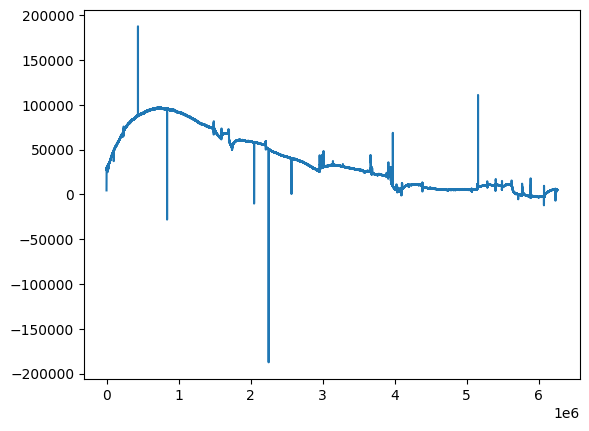

In [11]:
plt.plot(raw)

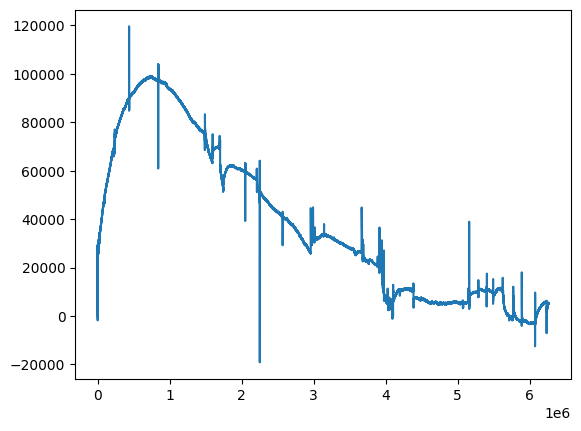

In [10]:
plt.plot(filtered4lac)

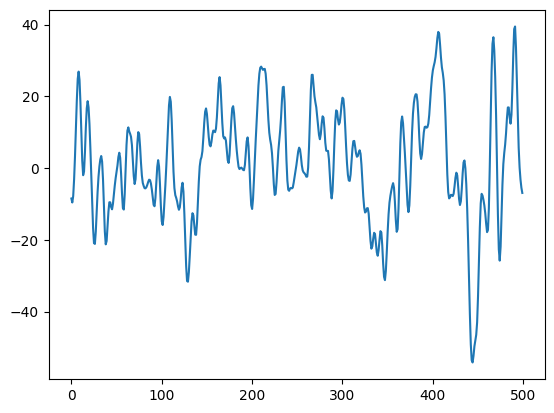

In [20]:
plt.plot(detrended_data[2000000:2000500])

In [22]:
print(f"Running Lacourse")
data_detect = np.array(detrended_data)
mask = np.ones(len(data_detect), dtype=bool)
lacourse = detect_lacourse(
    data_detect,
    mask,
    sampling_rate=250,
)

Running Lacourse


/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/wonambi/detect/spindle.py:1521: RuntimeWarning: divide by zero encountered in scalar divide
  out[i] = (dat[i] - mean(windat)) / std(stddat)


In [36]:
# Run lacourse in segments of one hour
lacourse_seg = []
length_seg = 250 * 60 * 60
for i in range(0, len(data_detect), length_seg):
    if i + length_seg > len(data_detect):
        data_detect_seg = data_detect[i:]
    else:  
        data_detect_seg = data_detect[i:i+length_seg]

    mask = np.ones(len(data_detect_seg), dtype=bool)
    segmented_lac = detect_lacourse(
        data_detect_seg,
        mask,
        sampling_rate=250,
    )
    lacourse_seg += [[x + i for x in seg_spindle] for seg_spindle in segmented_lac]

/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/wonambi/detect/spindle.py:1521: RuntimeWarning: divide by zero encountered in scalar divide
  out[i] = (dat[i] - mean(windat)) / std(stddat)


In [39]:
len(lacourse_seg)

1307

In [66]:
path = '/project/portinight-raw/PN_05_EC/'
save_path = '/project/portinight-dataset/'
subject_id = 'PN_05_EC'
age = 24
gender = 'F'

# Iterate through all the csvs in the folder
data = {}
for idx, file in enumerate(os.listdir(path)):
    if file.endswith(".csv"):
        print(f"Processing {file}")

        # Get the filename
        filename = file.split('_')[:-1]
        filename = '_'.join(filename)

        df = pd.read_csv(path + file, on_bad_lines='warn', encoding_errors='ignore')
        # convert useful data to floats
        df['converted'] = pd.to_numeric(df.iloc[:, 1], errors='coerce')
        df['converted'] = df['converted'].fillna(method='ffill')
        useful_data = df['converted'].values
        filtered4lac, lacourse, filtered_online = raw2filtered(useful_data)

        if filtered4lac is None:
            print(f"No spindles found in {file}, skipping")
            continue

        spindle_info_mass = {}
        spindle_info_mass[filename] = {
            'onsets': [],
            'offsets': [],
            'labels_num': []
        }

        for spindle in lacourse:
            spindle_info_mass[filename]['onsets'].append(spindle[0])
            spindle_info_mass[filename]['offsets'].append(spindle[1])
            spindle_info_mass[filename]['labels_num'].append(1)

        data[filename] = {}

        data[filename]['age'] = age
        data[filename]['gender'] = gender
        data[filename]['signal_mass'] = filtered4lac
        data[filename]['signal_filt'] = filtered_online
        data[filename]['ss_label'] = np.ones(len(filtered4lac)) * 5
        data[filename]['spindle_mass_lacourse'] = spindle_info_mass

print(f"Saving f{subject_id}.npz")
np.savez_compressed(os.path.join(save_path, f"{subject_id}.npz"), data)


Processing PN_05_EC_Night4_Sham.csv


Skipping line 2233136: expected 7 fields, saw 10
Skipping line 2233229: expected 7 fields, saw 11

Skipping line 2416571: expected 7 fields, saw 9

Skipping line 2814674: expected 7 fields, saw 8

Skipping line 3565848: expected 7 fields, saw 8

Skipping line 4763812: expected 7 fields, saw 10

Skipping line 5900663: expected 7 fields, saw 8

Skipping line 6283234: expected 7 fields, saw 9

/tmp/ipykernel_1309187/3439872492.py:17: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + file, on_bad_lines='warn', encoding_errors='ignore')
/tmp/ipykernel_1309187/3439872492.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['converted'] = df['converted'].fillna(method='ffill')


Filtering Data Online


  0%|          | 0/7506665 [00:00<?, ?it/s]/tmp/ipykernel_1309187/1879190733.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value[i] = x
100%|██████████| 7506665/7506665 [02:51<00:00, 43702.26it/s]


Detrending Data
Running Lacourse
Processing PN_05_EC_Night3_Stim.csv


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [36]:
# Count how many NaNs are in the data
df['converted'].isna().sum()

0

In [8]:
save_path = '/project/MASS/mass_spindles_dataset'
# save_path = '/project/portinight-dataset/'
subject_id = 'PN_02_MS'

# Try loading the portinight data:
data = np.load(os.path.join(save_path, f"{subject_id}.npz"), allow_pickle=True)

In [9]:
data = data['arr_0'].item()
data.keys()

dict_keys(['PN_02_MS_Night2', 'PN_02_MS_Night3', 'PN_02_MS_Night1', 'PN_02_MS_Night4'])

In [77]:
len(data['PN_05_EC_Night2']['signal_mass'])

7118999

In [69]:
# Save the cleaned data
np.savez_compressed(os.path.join(save_path, f"{subject_id}.npz"), data)

In [2]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import MassDataset

data_path = '/project/MASS/mass_spindles_dataset/'
subjects = ['PN_01_HJ_Night4', '01-01-0001']

dataset = MassDataset(data_path, 30, 30, 30, subjects=subjects, use_filtered=False, sampleable='spindles', compute_spindle_labels=False)

Time taken to load PN_01_HJ_Night4: 7.2182457447052
Time taken to load 01-01-0001: 2.9380064010620117
Time taken to create lookup table: 1.574547290802002
Number of sampleable indices: 14841701
Number of spindle indexes: 422714
Number of spindles: 2301
Number of N1 indexes: 0
Number of N2 indexes: 0
Number of N3 indexes: 0
Number of R indexes: 0
Number of W indexes: 0


In [5]:
# Read the list of subjects from the file
subject_list_path = '/project/MASS/mass_spindles_dataset/subjects_portinight.txt'

with open(subject_list_path, 'r') as f:
    subjects = f.readlines()

subjects = [x.strip() for x in subjects]

subject = subjects[12]
print(subject)

dataset = MassDataset(data_path, 30, 30, 30, subjects=[subject], use_filtered=False, sampleable='spindles', compute_spindle_labels=False)

PN_04_GB_Night5_Sham
Time taken to load PN_04_GB_Night5_Sham: 6.58555793762207
Time taken to create lookup table: 0.10268807411193848
Number of sampleable indices: 1372065
Number of spindle indexes: 0
Number of spindles: 0
Number of N1 indexes: 0
Number of N2 indexes: 0
Number of N3 indexes: 0
Number of R indexes: 0
Number of W indexes: 0


In [11]:
len(dataset.data['PN_04_GB_Night5_Sham']['signal'])

1372964

In [10]:
# Iterate through all files in the dataset and list all the files
save_path = '/project/MASS/mass_spindles_dataset'

subject_names = []
for file in os.listdir(save_path):
    if file.startswith("PN_"):
        print(f"Processing {file}")
        data = np.load(os.path.join(save_path, file), allow_pickle=True)
        data = data['arr_0'].item()
        subject_names += list(data.keys())
        print(data.keys())
        for key in data.keys():
            print(key)
            print(data[key].keys())
            print(data[key]['signal_mass'].shape)
            print(data[key]['signal_filt'].shape)
            print(data[key]['ss_label'].shape)   

Processing PN_06_MA.npz
dict_keys(['PN_06_MAS_Night6', 'PN_06_MAS_Night2', 'PN_06_MAS_Night4', 'PN_06_MAS_Night3', 'PN_06_MAS_Night5', 'PN_06_MAS_Night1'])
PN_06_MAS_Night6
dict_keys(['age', 'gender', 'signal_mass', 'signal_filt', 'ss_label', 'spindle_mass_lacourse'])
(8351999,)
(8351999,)
(8351999,)
PN_06_MAS_Night2
dict_keys(['age', 'gender', 'signal_mass', 'signal_filt', 'ss_label', 'spindle_mass_lacourse'])
(7085864,)
(7085864,)
(7085864,)
PN_06_MAS_Night4
dict_keys(['age', 'gender', 'signal_mass', 'signal_filt', 'ss_label', 'spindle_mass_lacourse'])
(6897423,)
(6897423,)
(6897423,)
PN_06_MAS_Night3
dict_keys(['age', 'gender', 'signal_mass', 'signal_filt', 'ss_label', 'spindle_mass_lacourse'])
(6750854,)
(6750854,)
(6750854,)
PN_06_MAS_Night5
dict_keys(['age', 'gender', 'signal_mass', 'signal_filt', 'ss_label', 'spindle_mass_lacourse'])
(8545854,)
(8545854,)
(8545854,)
PN_06_MAS_Night1
dict_keys(['age', 'gender', 'signal_mass', 'signal_filt', 'ss_label', 'spindle_mass_lacourse'])
(

In [11]:
subject_names

['PN_06_MAS_Night6',
 'PN_06_MAS_Night2',
 'PN_06_MAS_Night4',
 'PN_06_MAS_Night3',
 'PN_06_MAS_Night5',
 'PN_06_MAS_Night1',
 'PN_08_AC_Night6a',
 'PN_08_AC_Night6b',
 'PN_08_AC_Night5',
 'PN_08_AC_Night2',
 'PN_08_AC_Night3',
 'PN_08_AC_Night4',
 'PN_04_GB_Night5_Sham',
 'PN_04_GB_Night4',
 'PN_04_GB_Night6',
 'PN_04_GB_Night2',
 'PN_04_GB_Night3',
 'PN_04_GB_Night1',
 'PN_02_MS_Night4',
 'PN_02_MS_Night2',
 'PN_02_MS_Night6',
 'PN_02_MS_Night5',
 'PN_02_MS_Night3',
 'PN_02_MS_Night1',
 'PN_05_EC_Night3',
 'PN_05_EC_Night1',
 'PN_05_EC_Night4',
 'PN_05_EC_Night2',
 'PN_01_HJ_Night1',
 'PN_01_HJ_Night4',
 'PN_01_HJ_Night5',
 'PN_01_HJ_Night6',
 'PN_01_HJ_Night3',
 'PN_03_CL_Night3',
 'PN_03_CL_Night6',
 'PN_03_CL_Night4',
 'PN_03_CL_Night2',
 'PN_03_CL_Night1',
 'PN_07_CB_NightD',
 'PN_07_CB_NightE',
 'PN_07_CB_NightF',
 'PN_07_CB_NightC']

In [21]:
# Write all the subject names to a file
subject_list_path = '/project/MASS/mass_spindles_dataset/subjects_portinight.txt'

with open(subject_list_path, 'w') as f:
    for subject in subject_names:
        f.write(f"{subject}\n")
        